**1. Wczytanie danych oraz potrzebnych pakietów**


In [1]:
#import bibliotek

import os
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf

#zaczytanie dancyh

Test_Set = "C:/Users/Szymon/Downloads/Xray/test/"
Train_Set = "C:/Users/Szymon/Downloads/Xray/train/"
Val_Set = "C:/Users/Szymon/Downloads/Xray/val/"





***Rzut oka na dane*** - wstępna eksploracja

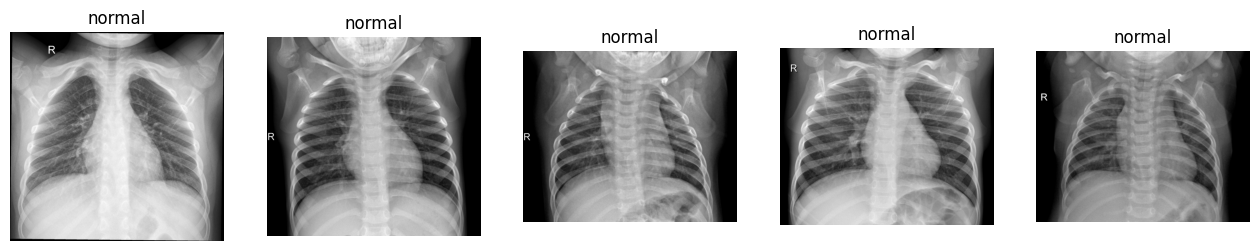

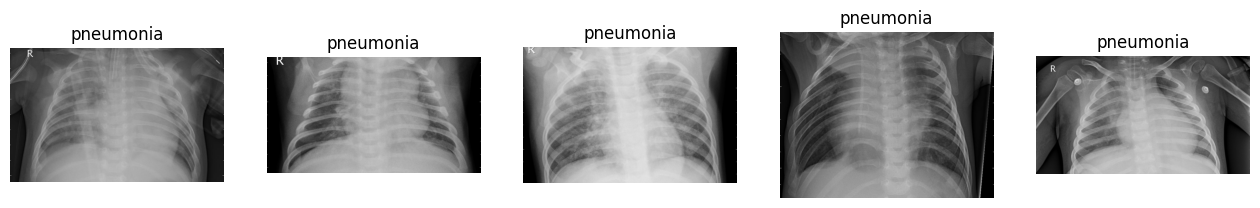

In [2]:
#funkcja która wyświetla randomowe obrazki ze zbioru dla obu klas

def wyswietl_dane(Set, klasa):
    plt.figure(figsize=(16, 16))
    
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        
        #Ścieżka do obrazu jest wybierana poprzez dodanie / i nazwy klasy
        random_img = random.choice(os.listdir(Set + '/' + klasa))
        img = cv2.imread(Set + '/' + klasa + '/' + random_img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.imshow(img)
        plt.title(klasa)
        plt.axis('off')
        
    plt.show()

# Wyświetlam randomowe obrazki z obu klas
wyswietl_dane(Train_Set, "normal")
wyswietl_dane(Train_Set, "pneumonia")
        
        
        

**Rozkład Klas**

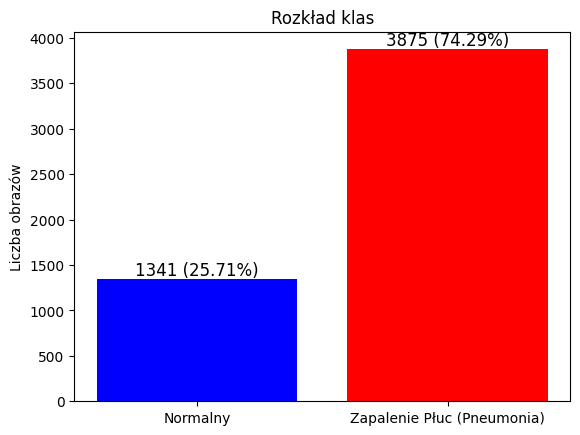

In [24]:
def Rozklad(Set):
    normal_images = len(os.listdir(Set + "normal"))
    pneumonia_images = len(os.listdir(Set + "pneumonia"))
    total_images = normal_images + pneumonia_images
    
    Klasa = ['Normalny', 'Zapalenie Płuc (Pneumonia)']
    counts = [normal_images, pneumonia_images]
    
    normal_percentage = (normal_images / total_images) * 100
    pneumonia_percentage = (pneumonia_images / total_images) * 100
    
    plt.bar(Klasa, counts, color=['blue', 'red'])
    plt.title(f"Rozkład klas")
    plt.ylabel("Liczba obrazów")
    
    for i, count in enumerate(counts):
        plt.text(i, count, f"{count} ({normal_percentage if i == 0 else pneumonia_percentage:.2f}%)",
                 ha='center', va='bottom', fontsize=12, color='black')
    
    plt.show()


Rozklad(Train_Set)

Dzięki wizualizacji rozkładu klas dowiedzieliśmy się, że zbiór treningowy jest zdecydowanie niezbalasnowany. Niezbalansowane dane mogą prowadzić do zmniejszenia dokładność naszego modelu.

**Przygotowanie Danych**

In [2]:
# Funkcja definująca standardowy format obrazów przy pomoc modułu tf.keras.preprocessing.image
IMG_SIZE = (150, 150)

def Format(Set, klasa):
    obrazy = []
    for img_name in os.listdir(Set + '/' + klasa):
        img = tf.keras.preprocessing.image.load_img(Set + '/' + klasa + '/' + img_name, target_size=IMG_SIZE)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        obrazy.append(img_array)
    return obrazy

normal_train_format = Format(Train_Set, "normal")
pneumonia_train_format = Format(Train_Set, "pneumonia")

In [3]:
# Zaczytywanie obrazów
def Wczytaj_Obrazy(set, klasa, num_images=250):
    obrazy = []
    Wybrane_obrazy = random.sample(os.listdir(set + '/' + klasa), num_images)
    
    for img_name in Wybrane_obrazy:
        img = tf.keras.preprocessing.image.load_img(set + '/' + klasa + '/' + img_name, target_size=IMG_SIZE)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        obrazy.append(img_array)
    
    return obrazy


normal_train = Wczytaj_Obrazy(Train_Set, "normal")
pneumonia_train = Wczytaj_Obrazy(Train_Set, "pneumonia")


Nadawanie etykiet dla obrazów w podzbiorze

In [4]:
X_train_set = normal_train + pneumonia_train
y_train_set = [0]*len(normal_train) + [1]*len(pneumonia_train)

Podział podzbioru na treningowe i walidaycje

In [5]:
from sklearn.model_selection import train_test_split

X_train_set, X_val_set, y_train_set, y_val_set = train_test_split(X_train_set, y_train_set, test_size=0.2, stratify=y_train_set)

Normalizacja danych wchodzących do modelu

In [6]:
X_train_set = [img/255.0 for img in X_train_set]
X_val_set = [img/255.0 for img in X_val_set]

**Budowa Modelu oraz jego trening**

In [7]:
# Budowa Modelu
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Kompilacja Modelu
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
class StopAtAccuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 1.0:
            print("\nReached 100% accuracy, zatrzymać trening!")
            self.model.stop_training = True

# instancja zwrotna
stop_at_1_accuracy = StopAtAccuracy()

In [9]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Trening modelu


In [10]:
# Trening modelu
history = model.fit(
    x=np.array(X_train_set), 
    y=np.array(y_train_set), 
    epochs=25,
    validation_data=(np.array(X_val_set), np.array(y_val_set)),
    callbacks=[early_stop, stop_at_1_accuracy]
)

Epoch 1/25
13/13 [==============================] - 15s 903ms/step - loss: 1.3637 - accuracy: 0.4575 - val_loss: 0.6709 - val_accuracy: 0.8900
Epoch 2/25
13/13 [==============================] - 10s 714ms/step - loss: 0.5954 - accuracy: 0.7600 - val_loss: 0.4980 - val_accuracy: 0.7300
Epoch 3/25
13/13 [==============================] - 8s 651ms/step - loss: 0.3582 - accuracy: 0.8675 - val_loss: 0.4184 - val_accuracy: 0.8300
Epoch 4/25
13/13 [==============================] - 8s 653ms/step - loss: 0.2097 - accuracy: 0.9125 - val_loss: 0.3051 - val_accuracy: 0.8800
Epoch 5/25
13/13 [==============================] - 8s 654ms/step - loss: 0.1369 - accuracy: 0.9525 - val_loss: 0.2494 - val_accuracy: 0.9100
Epoch 6/25
13/13 [==============================] - 9s 663ms/step - loss: 0.1457 - accuracy: 0.9400 - val_loss: 0.2455 - val_accuracy: 0.9100
Epoch 7/25
13/13 [==============================] - 9s 663ms/step - loss: 0.0675 - accuracy: 0.9800 - val_loss: 0.1158 - val_accuracy: 0.9700
Epoc

**Ewaluacja Modelu**

In [11]:
# Formatownie zbioru testowego
normal_test_images = Format(Test_Set, "normal")
pneumonia_test_images = Format(Test_Set, "pneumonia")

X_test = normal_test_images + pneumonia_test_images
y_test = [0]*len(normal_test_images) + [1]*len(pneumonia_test_images)

# Normalizacja zbioru testowego
X_test = [img/255.0 for img in X_test]

# Predykcja na zbiorze testowym
y_pred_probs = model.predict(np.array(X_test))
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_probs]

20/20 [==============================] - 5s 227ms/step


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8333
Precision: 0.8017
Recall: 0.9744
F1 Score: 0.8796


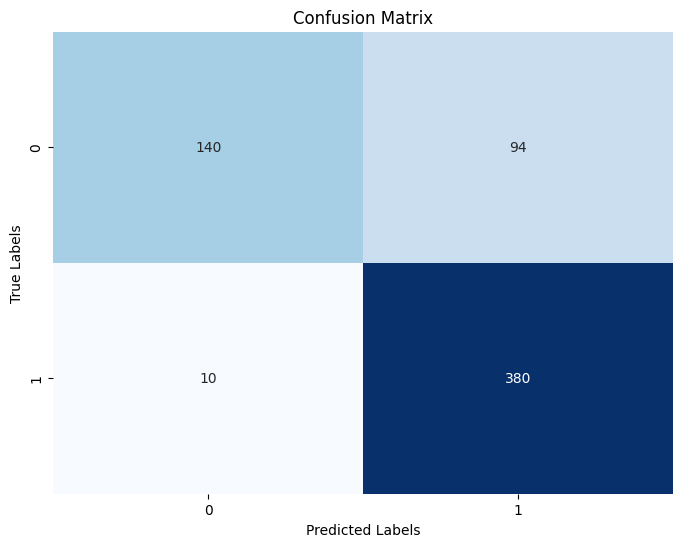

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Macierz Pomyłek
cm = confusion_matrix(y_test, y_pred)

# Wizualizacja Macierzy Pomyłek
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

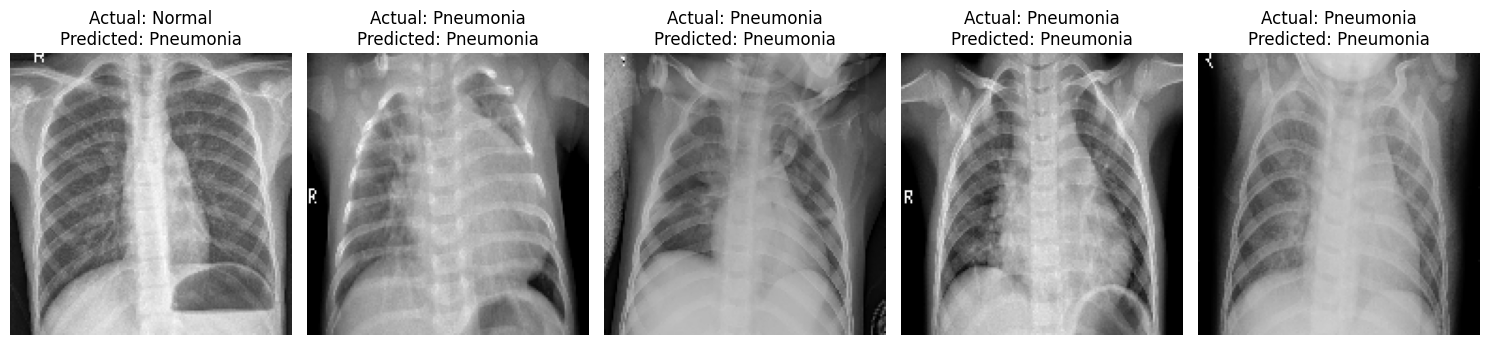

In [14]:
def display_random_test_images(X_test, y_test, y_pred, num_images=5):
    plt.figure(figsize=(15, 5))
    
    for i in range(num_images):
        idx = random.randint(0, len(X_test) - 1)
        plt.subplot(1, num_images, i + 1)
        
        plt.imshow(X_test[idx])
        plt.title(f"Actual: {'Pneumonia' if y_test[idx] == 1 else 'Normal'}\nPredicted: {'Pneumonia' if y_pred[idx] == 1 else 'Normal'}")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

display_random_test_images(X_test, y_test, y_pred)

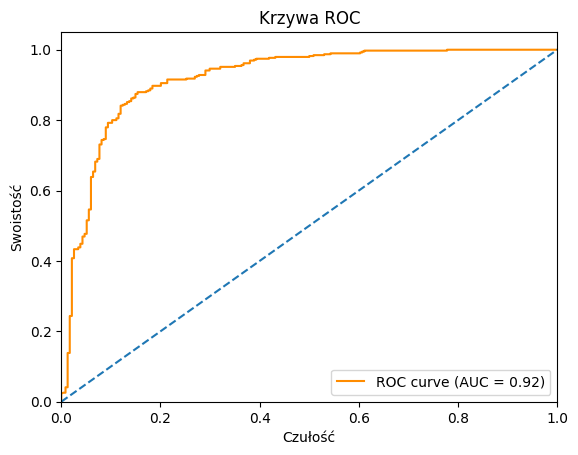

In [15]:
#Krzywa ROC

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


y_score = y_pred_probs  

fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Czułość')
plt.ylabel('Swoistość')
plt.title('Krzywa ROC')
plt.legend(loc="lower right")
plt.show()